In [4]:
import pandas as pd
from fyers_helper import prepare_data, load_stock_data
import datetime as dt

interval = "1D"

nifty200_df = pd.read_csv('nifty200.csv')
tickers = [ f'NSE:{n}-EQ' for n in nifty200_df.Symbol.tolist()]

data_path = "../data"

end_date = dt.datetime.now()
start_date = dt.datetime(2015, 1, 1)

file_paths = prepare_data(tickers, interval, start_date=start_date, end_date=end_date, path=data_path, overwrite=False)
loaded_data_1D = load_stock_data(file_paths, data_path, interval)

df = pd.concat(loaded_data_1D, names=["Stock", "Date"]).reset_index()

Loading 1Dmin data: 100%|██████████| 200/200 [00:00<00:00, 598.20it/s]


In [39]:
from lib import Bank, PositionManager, generate_tearsheet
import talib as ta
from tqdm.notebook import tqdm
import numpy as np

def backtest(_df, pm: PositionManager, params, show_pb=False):
    max_positions = params['max_positions']
    bb_period = int(params['bb_period'])
    bb_sd = params['bb_sd']
    start_date = params['start_date']
    end_date = params['end_date']
    initial_capital = params['initial_capital']

    def calc_bbands(group):
        group = group.copy()
        group['upper_band'], group['middle_band'], group['lower_band'] = ta.BBANDS(group['Close'], bb_period, bb_sd, bb_sd, 0)
        return group

    _df = _df.groupby('Stock', group_keys=False).apply(calc_bbands)
    _df['close_below_lower_bb'] = np.where(_df.Close < _df.lower_band, 1, 0)
    # _df['close_below_lower_bb_3'] = _df.groupby('Stock')['close_below_lower_bb'].shift(3)
    _df['close_below_lower_bb_2'] = _df.groupby('Stock')['close_below_lower_bb'].shift(2)
    _df['close_below_lower_bb_1'] = _df.groupby('Stock')['close_below_lower_bb'].shift(1)

    # Regeim filter
    

    _df = _df[(_df.Date >= start_date) & (_df.Date < end_date)].reset_index()
    signals = _df[(_df.close_below_lower_bb_1 == 1) & (_df.close_below_lower_bb_2 == 1) & (_df.close_below_lower_bb == 1)].reset_index(drop=True)


    if show_pb:
        pb = tqdm(total=_df.Date.nunique(), desc="Backtesting...")

    for idx, group in _df.groupby('Date'):
        for position in pm.get_active_positions():
            stock = group[group.Stock == position.stock]
            if len(stock) < 1:
                continue
            try:
                if (stock.High.iloc[0] >= stock.middle_band.iloc[0]):
                    pm.close_position(position.stock, idx, stock.middle_band.iloc[0])

            except Exception as e:
                print(f"stock.Close - {stock.Close}")
                print(f"stock - {stock}")
                print(f"position - {position}")
                print(f"idx - {idx}")
                print(f"group - {group}")
                raise e
        
        day_signals = signals[signals.Date == idx]
        for signal in day_signals.itertuples():
            if pm.get_position(signal.Stock) is None:
                capital = round(pm.bank.total_capital() / max_positions, 2)
                position = pm.new_position(signal.Stock, idx, signal.Close, capital)


        if show_pb:
            pb.update(1)

    if show_pb:
        pb.close()

    return generate_tearsheet(initial_capital, pm)

/var/folders/rw/xc9yc4151v3_3lcv8h2n7pxr0000gn/T/ipykernel_4690/1751776380.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  _df = _df.groupby('Stock', group_keys=False).apply(calc_bbands)


Backtesting...:   0%|          | 0/908 [00:00<?, ?it/s]

                      Metrics                    Values
0                      Period  2022-01-06 to 2025-08-28
1            Starting capital                    500000
2               Final capital               1056127.636
3                Total Trades                       906
4                     Winners                       679
5                      Losers                       227
6               Profit factor                  1.643959
7       Active Position Count                         5
8   Max holding period (days)                        20
9   Avg holding period (days)                         3
10               Win Rate (%)                 74.944812
11               Total Profit                556127.636
12                 Avg Profit               2090.920866
13                   Avg Loss              -3804.438907
14            Total Brokerage                       0.0
15                  Total Tax                  48901.38
16                  Total MTF                   

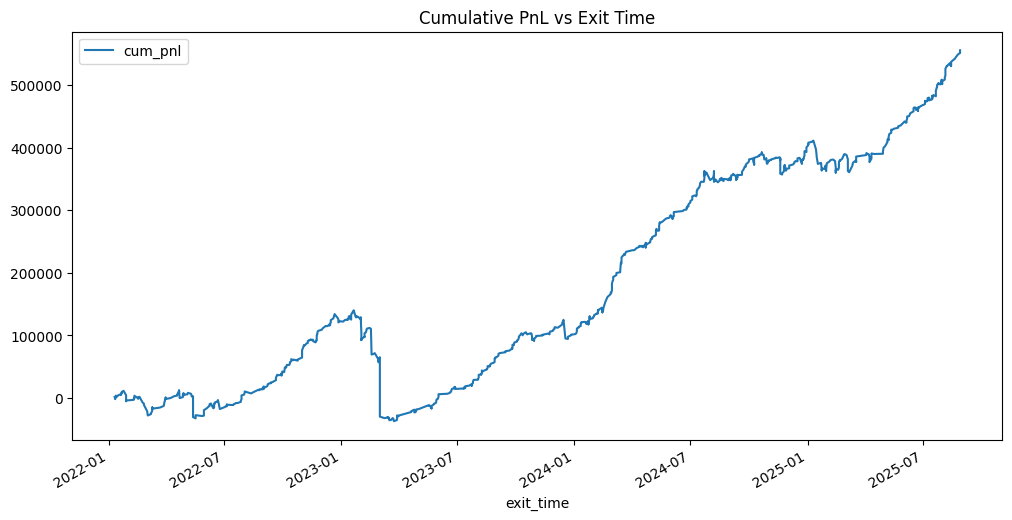

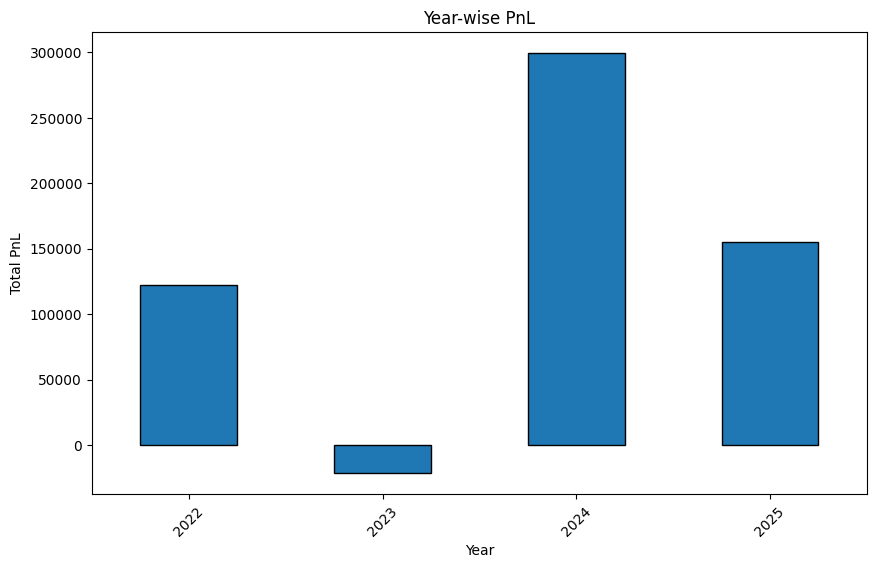

In [45]:
from lib import Bank, PositionManager, show_equity_curve

params = {
    'initial_capital': 500000,
    'max_positions': 5,
    'bb_period': 5,
    'bb_sd': 1.3,
    'start_date': '2022-01-01',
    'end_date': '2026-01-01',
}


bank = Bank(params['initial_capital'])
pm = PositionManager(bank)

tearsheet, trades = backtest(df.copy(), pm, params, show_pb=True)
print(pd.DataFrame({
    "Metrics": tearsheet.keys(),
    "Values": tearsheet.values(),
}))
show_equity_curve(trades)

In [27]:
trades[(trades.entry_time >= '2020-01-01') & (trades.entry_time < '2020-06-01')].to_csv('trades.csv', index=False)